In [1]:
from hossam import load_data

In [2]:
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

In [3]:
origin=load_data('cars')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리


===== 데이터 크기 확인 =====
데이터셋 크기 : (50, 2)
행 개수 : 50개
열 개수 : 2개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


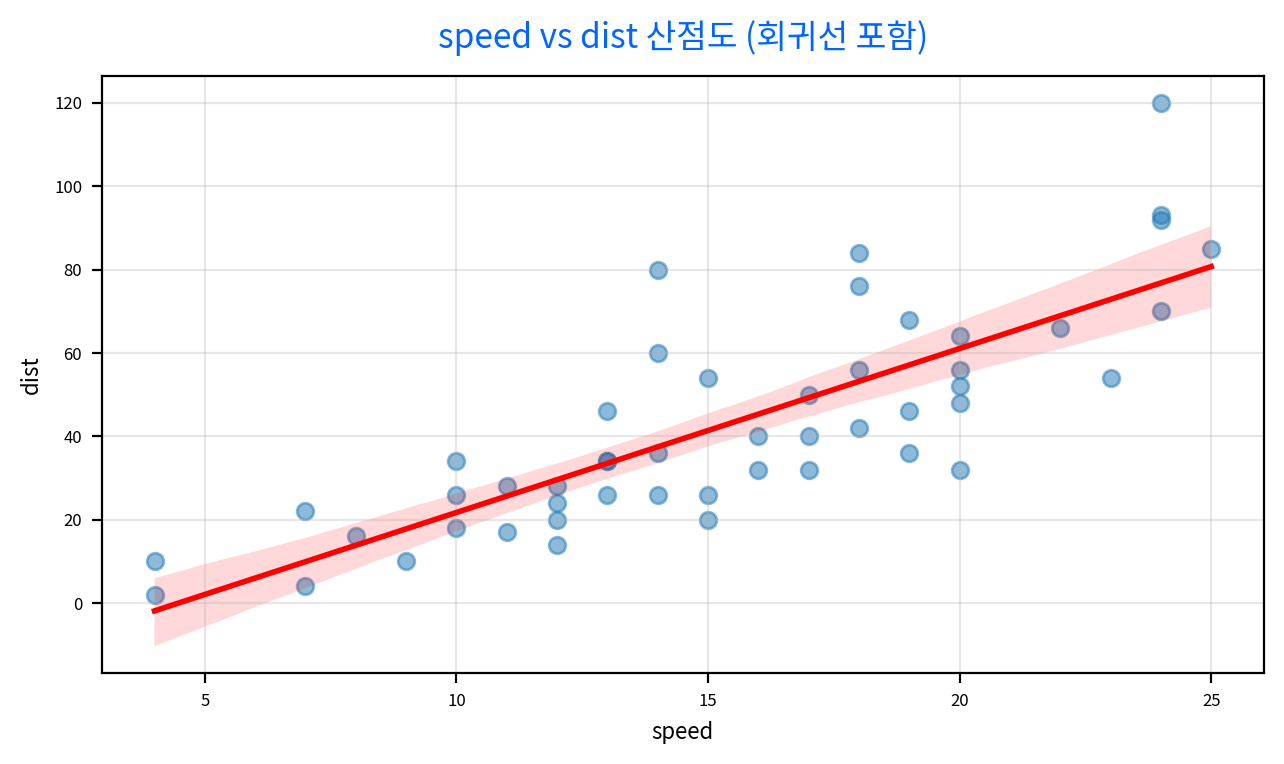

Ramsey RESET Test : 선형성 적합 (p-value : 0.1364)


,original_skew,log_skew,outliers(|z|>3),log_recommended
speed,-0.11751,-1.668586,0,False
dist,0.806895,-1.384501,1,False


이상치가 발견되어 스피어만 상관계수 사용
📊 상관계수 요약
Pearson r: 0.807, p-value: 0.0000
Spearman rho: 0.830, p-value: 0.0000

✅ 최종 선택 결과
선택된 방법: spearman
상관계수: 0.830
p-value: 0.0000
선택 근거: 비선형(또는 이상치 영향) 가능성 고려


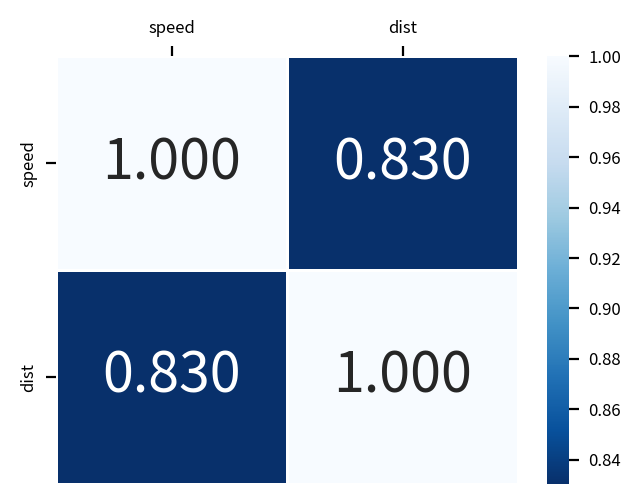


🎓 인사이트

본 분석에서는 speed와(과) dist 간 상관관계를 검토하였다.
데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.
분석 결과, 스피어만 상관계수는 rho=0.8304, p=0.0000로 나타나 두 변수간 유의한 양의 단조 관계가 통계적으로 유의함을 확인하였다.


In [15]:
# 데이터 입력
xdata='speed'
ydata='dist'

# 패키지 참조
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr, probplot, shapiro, kstest

from statsmodels.formula.api import ols
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# 그래프 초기화
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

# 산점도 그래프
width_px=1280
height_px=760
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(data=origin, x=xdata, y=ydata, scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
ax.grid(True, alpha=0.3)
ax.set_title(f'{xdata} vs {ydata} 산점도 (회귀선 포함)', color='#0066ff', fontsize=12, fontweight=1000, pad=10)
ax.set_xlabel(f'{xdata}', fontsize=8)
ax.set_ylabel(f'{ydata}', fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# 선형성 적합여부 판단
x=origin[xdata]
y=origin[ydata]
X=sm.add_constant(x)
model=sm.OLS(y,X).fit()
reset=linear_reset(model, power=2, use_f=True)
linearity_ok=reset.pvalue>0.05
print(f'Ramsey RESET Test : {"선형성 적합" if linearity_ok else "선형성 위반"} (p-value : {reset.pvalue:.4f})')

# 이상치와 왜도 검정
data=origin[[xdata, ydata]]
results={}
for col in data.columns:
    temp=data[col].dropna()
    # 왜도 계산
    skew_original=temp.skew()
    # Z-score 기반 이상치 탐지 (|z|>3)
    z_scores=zscore(temp)
    outlier_count=int(np.sum(np.abs(z_scores)>3))
    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log=np.log1p(temp-temp.min()+1)
    skew_log=data_log.skew()
    # 로그 변환 필요 여부 판단
    need_log=(abs(skew_original)>1) and (abs(skew_log)<abs(skew_original))
    results[col]={
        'original_skew':skew_original,
        'log_skew':skew_log,
        'outliers(|z|>3)':outlier_count,
        'log_recommended':need_log
    }
results_df=pd.DataFrame(results).T
display(results_df)
outlier_flag=len(results_df[results_df['outliers(|z|>3)']>0])>0
if outlier_flag:
    print('이상치가 발견되어 스피어만 상관계수 사용')
else:
    print('이상치가 발견되지 않아 피어슨 상관계수 사용')

# 상관 분석
pearson_r, pearson_p=pearsonr(origin[xdata], origin[ydata])
spearman_r, spearman_p=spearmanr(origin[xdata], origin[ydata])
if linearity_ok and not outlier_flag:
    chosen='pearson'
    corr, pval=pearson_r, pearson_p
    rationale='선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen='spearman'
    corr, pval=spearman_r, spearman_p
    rationale='비선형(또는 이상치 영향) 가능성 고려'
print('='*50)
print('📊 상관계수 요약')
print('='*50)
print(f'Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}')
print(f'Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}')
print('\n'+'='*50)
print('✅ 최종 선택 결과')
print('='*50)
print(f'선택된 방법: {chosen}')
print(f'상관계수: {corr:.3f}')
print(f'p-value: {pval:.4f}')
print(f'선택 근거: {rationale}')
print('='*50)

# 상관 행렬
corr_matrix=origin[[xdata, ydata]].corr(method=chosen)
width_px=650
height_px=500
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':20})
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.tight_layout()
plt.show()
plt.close()

# 인사이트
print('\n'+'='*50)
print('🎓 인사이트')
print(f'\n본 분석에서는 {xdata}와(과) {ydata} 간 상관관계를 검토하였다.')
if chosen=='pearson':
    print('데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.')
    print(f'분석 결과, 피어슨 상관계수는 r={pearson_r:.4f}, p={pearson_p:.4f}로 나타나 두 변수간 유의한','양의 상관관계가' if pearson_r>0 else '음의 상관관계가', '통계적으로 유의함을 확인하였다.')
else:
    print('데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.')
    print(f'분석 결과, 스피어만 상관계수는 rho={spearman_r:.4f}, p={spearman_p:.4f}로 나타나 두 변수간 유의한','양의 단조 관계가' if spearman_r>0 else '음의 단조 관계가', '통계적으로 유의함을 확인하였다.')
print('='*50)

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        15:13:57   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

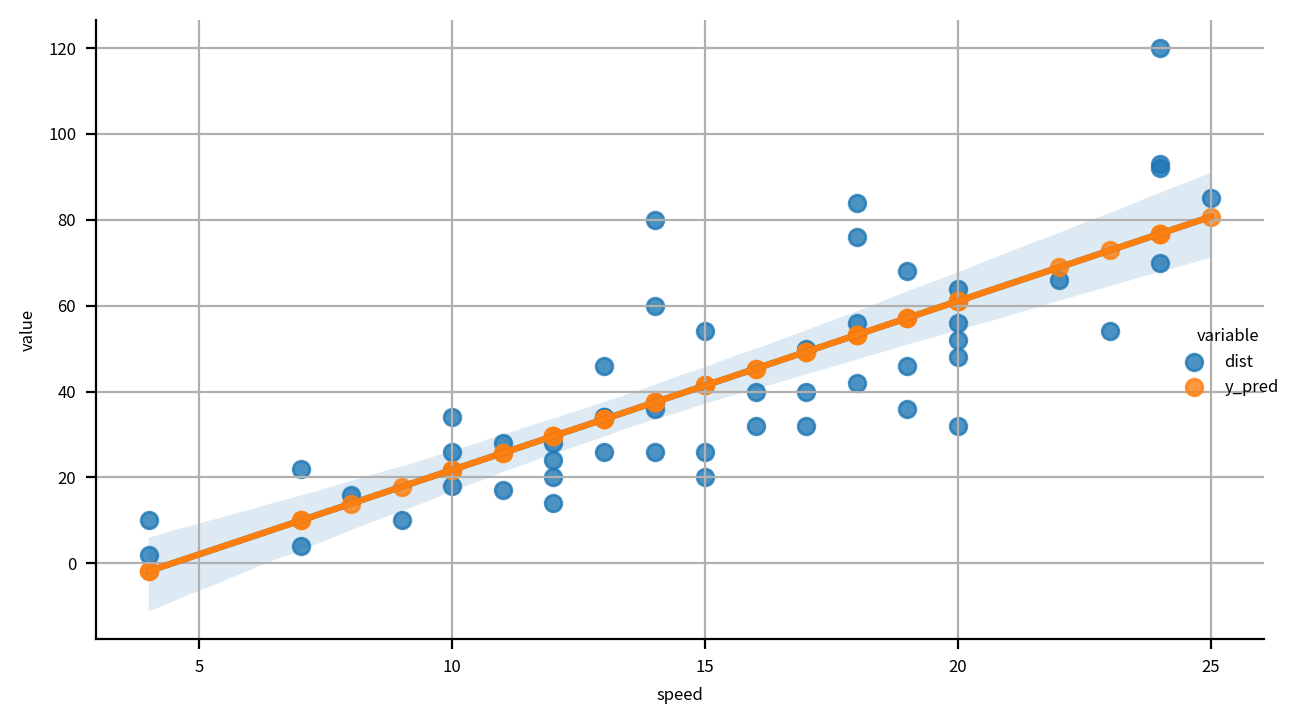

In [5]:
# 데이터 입력
xname='speed'
yname='dist'

# 패키지 참조
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

# 그래프 초기화
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

# 단순선형회귀분석
x=origin[[xname]]
y=origin[yname]
X=sm.add_constant(x)
model=sm.OLS(y,X)
fit=model.fit()
print(fit.summary())

# 그래프 시각화
df=origin.copy()
df['y_pred']=fit.predict(X)
df_melt=df.melt(
    id_vars=xname,
    value_vars=[yname,'y_pred'],
    var_name='variable',
    value_name='value'
)
width_px=1280
height_px=720
figsize=(width_px/my_dpi, height_px/my_dpi)
g=sb.lmplot(data=df_melt, x=xname, y='value', hue='variable')
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

In [6]:
y_pred=fit.predict(X)
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

In [7]:
y_pred=fit.fittedvalues
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

In [8]:
residual=origin['dist']-y_pred
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

In [9]:
residual=fit.resid
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

In [10]:
df=origin.copy()
df['y_pred']=y_pred
df['resid']=residual
df.head()

,speed,dist,y_pred,resid
0,4,2,-1.849460,3.849460
1,4,10,-1.849460,11.849460
2,7,4,9.947766,-5.947766
3,7,22,9.947766,12.052234
4,8,16,13.880175,2.119825


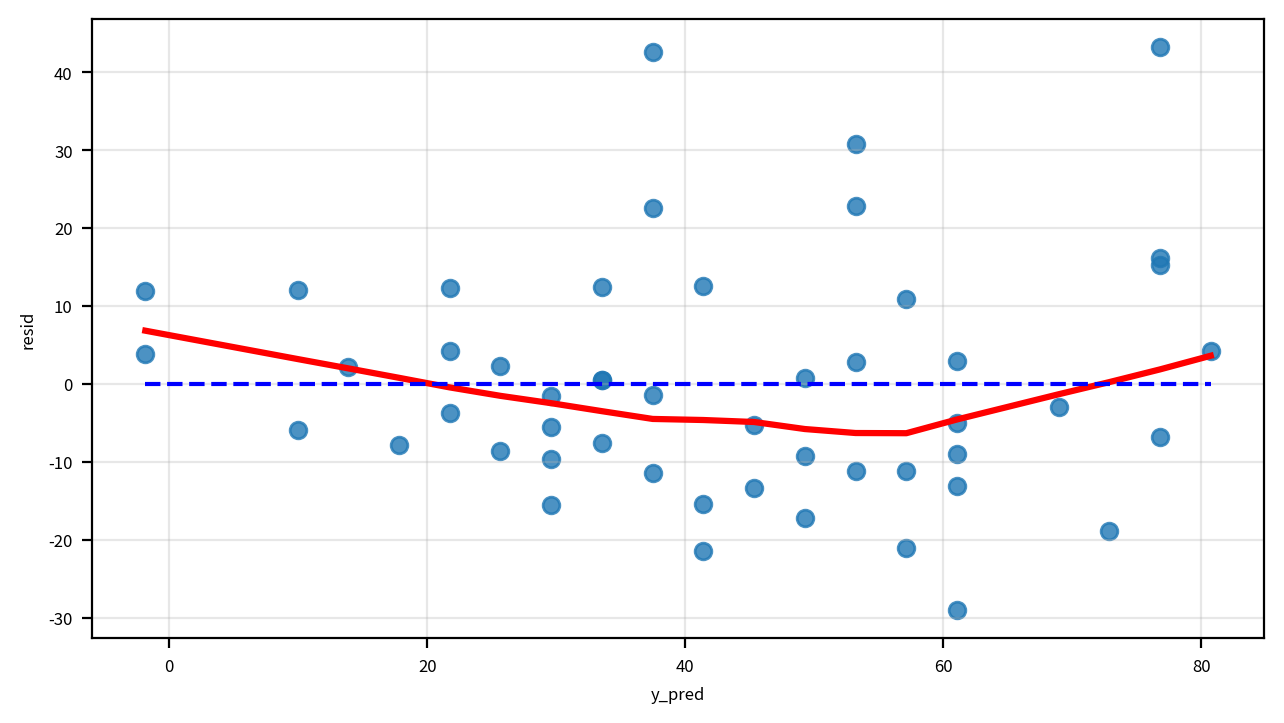

In [11]:
xmin=df['y_pred'].min()
xmax=df['y_pred'].max()
xrange=[xmin, xmax]
yrange=[0,0]

width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=df, x='y_pred', y='resid', lowess=True, line_kws={'color':'red'})
sb.lineplot(x=xrange, y=yrange, color='blue', linestyle='--')

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [12]:
reset_res=linear_reset(fit, power=2, use_f=True)
print(f'RESET F-statistic: {reset_res.fvalue:.4f}')
print(f'p-value: {reset_res.pvalue:.4f}')

if reset_res.pvalue<0.05:
    print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
    print('선형성 가정 위배 근거 없음 (5% 유의수준)')

RESET F-statistic: 2.2960
p-value: 0.1364
선형성 가정 위배 근거 없음 (5% 유의수준)


In [13]:
df['zscore']=zscore(df['y_pred'])
df.head()

,speed,dist,y_pred,resid,zscore
0,4,2,-1.849460,3.849460,-2.177858
1,4,10,-1.849460,11.849460,-2.177858
2,7,4,9.947766,-5.947766,-1.604738
3,7,22,9.947766,12.052234,-1.604738
4,8,16,13.880175,2.119825,-1.413697


In [16]:
(x,y),_=probplot(df['zscore'])
display(x[:5])
display(y[:5])

array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759])

array([-2.17785805, -2.17785805, -1.60473751, -1.60473751, -1.41369733])

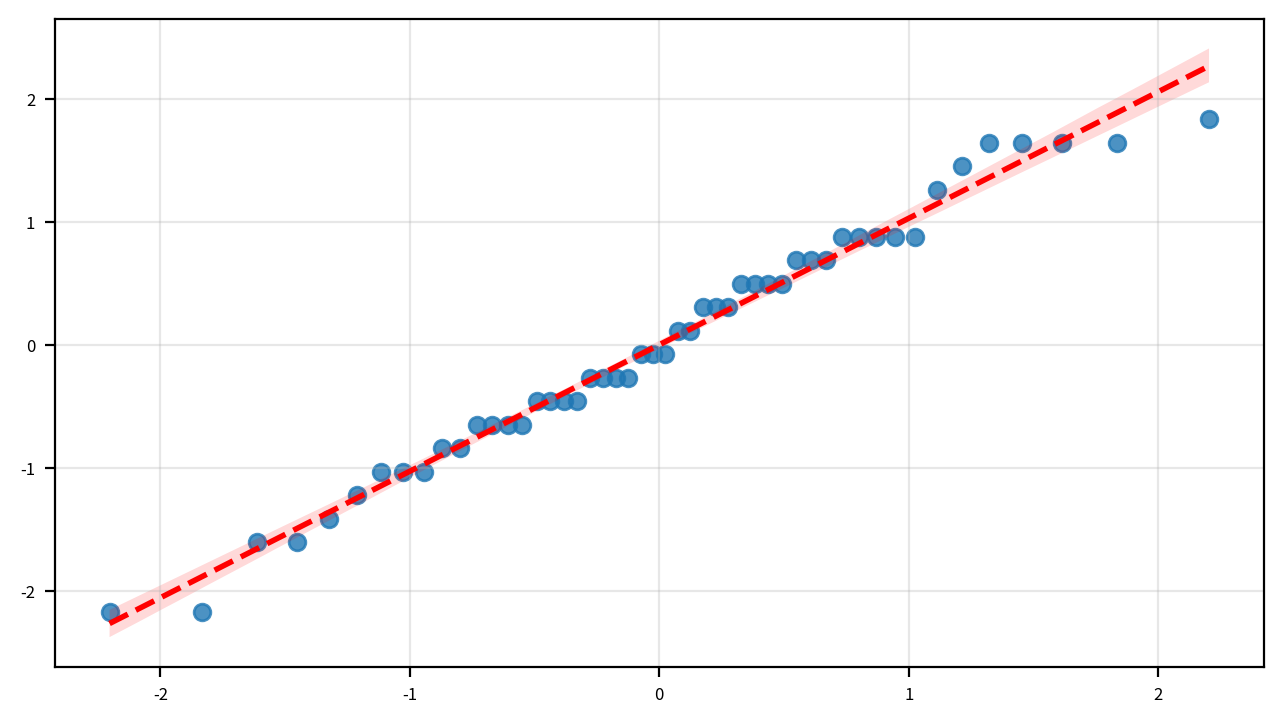

In [17]:
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(x=x, y=y, line_kws={'color':'red', 'linestyle':'--', 'linewidth':2})

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [18]:
MSE_sq=np.sqrt(fit.mse_resid)
r=fit.resid

r1=r[(r>-MSE_sq)&(r<MSE_sq)].count()/r.count()*100
r2=r[(r>-2*MSE_sq)&(r<2*MSE_sq)].count()/r.count()*100
r3=r[(r>-3*MSE_sq)&(r<3*MSE_sq)].count()/r.count()*100
mse_r=[r1,r2,r3]

print(f'루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%')
print(f'루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%')
print(f'루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%')

루트 1MSE 구간에 포함된 잔차 비율: 74.00%
루트 2MSE 구간에 포함된 잔차 비율: 94.00%
루트 3MSE 구간에 포함된 잔차 비율: 100.00%


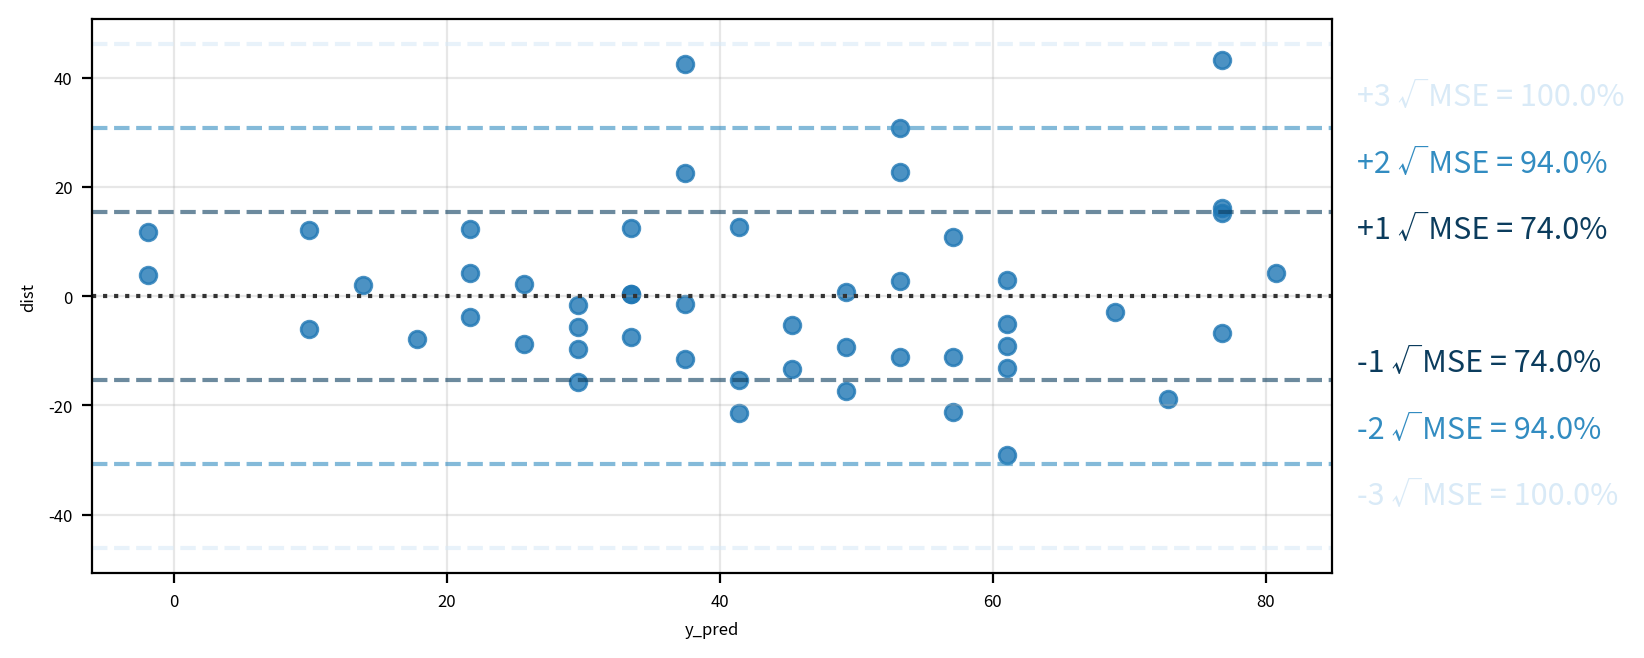

In [20]:
mse_sq=fit.mse_resid
mse_root=np.sqrt(mse_sq)
colors=['#0B3C5D', '#328CC1', '#D9EAF7']

# xmax=df['y_pred'].max()

width_px=1600
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.residplot(data=df, x='y_pred', y='dist', ax=ax)

ax.grid(True, alpha=0.3)

for i, c in enumerate(colors):
    k=i+1

    y_pos=k*mse_root

    ax.axhline(y=y_pos, color=c, linestyle='--', alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle='--', alpha=0.6)

    ax.text(x=1.02, y=0.5+0.12*k,
            s=f'+{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
    
    ax.text(x=1.02, y=0.5-0.12*k,
            s=f'-{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)

# plt.tight_layout()
plt.show()
plt.close()

In [21]:
if len(origin)<30:
    method='Shapiro-Wilk'
    s, p=shapiro(df['resid'])
else:
    method='Kolmogorov-Smirnov'
    mu=df['resid'].mean()
    sigma=df['resid'].std(ddof=1)
    s, p=kstest(df['resid'], 'norm', args=(mu, sigma))

result=f'{method} Test ::: statistic: {s:.3f}, p-value: {p:.3f}, {'대립' if p<=0.05 else '귀무'}가설 채택'
print(result)

Kolmogorov-Smirnov Test ::: statistic: 0.130, p-value: 0.341, 귀무가설 채택


In [22]:
names=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test=het_breuschpagan(fit.resid, fit.model.exog)
bp=DataFrame(bp_test, index=names, columns=['value'])

display(bp)

p_bp=bp.loc['F p-value', 'value']

bp_result=(
    f'Breusch-Pagan Test ::: '
    f'F = {bp.loc['F Statistic', 'value']:.3f}, '
    f'p-value = {p_bp:.3f}, '
    f'{'대립' if p_bp<=0.05 else '귀무'}가설 채택 -> '
    f'{"이분산성 존재(등분산 아님)" if p_bp<0.05 else "등분산성 만족"}'
)

print(bp_result)

,value
LM Statistic,3.214880
LM p-value,0.072972
F Statistic,3.298361
F p-value,0.075597


Breusch-Pagan Test ::: F = 3.298, p-value = 0.076, 귀무가설 채택 -> 등분산성 만족


In [23]:
dw=durbin_watson(df['resid'])

if 1.5<=dw<=2.5:
    interpretation='잔차는 독립성을 만족함 (자기상관 없음)'
elif dw<1.5:
    interpretation='잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
else:
    interpretation='잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)'

print(f'Durbin-Watson={dw:.3f} ::: {interpretation}')

Durbin-Watson=1.676 ::: 잔차는 독립성을 만족함 (자기상관 없음)
